# ***Gerando um dataframe utilizando toBands***

Neste exemplo vamos criar um dataframe e analisar uma série temporal de NDVI, utilizando o método toBands.

1. Definir a área de estudo e a coleção de imagens
2. Cálcular índices de vegetação e água
3. Exportar dados 
4. Gerar Gráficos

# ***Instalação de Bibliotecas***

In [ ]:
!pip install earthengine-api
!pip install geemap
!pip install rasterio

In [15]:
import geemap    
import ee, datetime    # Google Earth Engine

import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio import plot as rasterplot

import pandas as pd
import numpy as np

from matplotlib import pyplot 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
ee.Authenticate()
ee.Initialize()

# ***AREA DE ESTUDO***

Para acessa a área de estudo visualize o [Link.]('https://code.earthengine.google.com/0d6598513af2dfe9480f0ee15e1092af')

In [4]:
talhao =ee.Geometry.Polygon(
        [[[-53.35307660925514, -29.64834442110997],
          [-53.35307660925514, -29.659831172280285],
          [-53.334708841921156, -29.659831172280285],
          [-53.334708841921156, -29.64834442110997]]])

In [ ]:
#Definição da área de estudo 
ROI_MAP = geemap.Map(location=[-29.6407,-53.3347],zoom_start=10)
ROI_MAP.add_basemap('HYBRID')

##Adicionando a feature  = Converte para Image (desenha o limite)
limite = ee.Image().paint(talhao, 0, 2)
ROI_MAP.addLayer(limite,{'palette':'blue'}, 'ROI')

ROI_MAP

# ***SELEÇÃO DE IMAGENS***

In [6]:
##Função para o cálculo dos índices
def indices(image):
  ndvi =  image.normalizedDifference(['B8', 'B4']).rename('NDVI');# Rouse 1973
  ndwi = image.normalizedDifference(['B3', 'B8']).rename ('NDWI'); ##Mc Feeters 1996
  
  return image.divide(10000).addBands([ndvi,ndwi])

In [7]:
##Agora vamos obter um ee.Image de um ee.ImageCollection
Sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR')\
         .filterBounds(ee.Geometry.Point([-53.34363523352272, -29.654311728213607]))\
         .filterDate('2017-01-01', '2022-03-31')\
         .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',1))\
         .map(indices)\
   

print('Nº total de imagens :', Sentinel2.size().getInfo())

Nº total de imagens : 49


In [9]:
# Nome das bandas disponíveis para nossa análise
print(Sentinel2.first().bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'NDVI', 'NDWI']


# ***EMPILHAR IMAGENS COMO BANDAS E BAIXAR A IMAGEM***

1. Vamos utilizar a coleção de imagens com a seleção da banda de interesse, neste caso o NDVI, e posteriormente vamos utilizar o método .toBands.

2. Ao utilizar o "toBands" empilhamos nossas imagens da coleção como bandas. Em resumo, teremos uma imagem com n bandas que correspondem a imagem1, imagem2, e imagem...n da nossa ImageCollection.

In [ ]:
##Método toBands
sentinel_tobands = Sentinel2.select(['NDVI']).toBands()
sentinel_tobands.bandNames().getInfo()

In [ ]:
##Função para download
download = geemap.ee_export_image_to_drive(sentinel_tobands,description='Sentinel_ToBands',
                                          region=talhao, 
                                          folder='MASTERCLASS', 
                                          scale=30,
                                          crs='EPSG:4674' , 
                                          max_pixels=1e13, 
                                          file_format='GeoTIFF') #Salvará as imagens automaticamente do Drive

Exporting Sentinel_ToBands ...


In [18]:
##Vamos abrir nossa image com as bandas do índice
img = rio.open('/content/drive/MyDrive/MASTERCLASS/Sentinel_ToBands.tif')

In [ ]:
#lendo como matriz
img = img.read()
img.shape

In [ ]:
#Transpose CxHxW para HxWxC
img = img.transpose([1,2,0])
img.shape

In [22]:
##seleciona ndvi da nossa lista
ndvi = img[:,:,:49] 

In [ ]:
#Reprojetando nossa matriz
ndvi2 = ndvi.reshape(ndvi.shape[0]*ndvi.shape[1],ndvi.shape[2])
ndvi2.shape

In [ ]:
#Reprojetando nossa matriz
ndvi2=ndvi2.transpose()
ndvi2.shape

In [28]:
##Após reprojetar nossa imagem para uma matrix, vamos converter para um dataframe
df = pd.DataFrame(ndvi2)

In [29]:
##Criando uma coluna de data e inserindo o período da nossas imagens
df['data'] = pd.date_range(start='2018-12-29', end='2022-03-28', periods=49)

In [30]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3027,3028,3029,3030,3031,3032,3033,3034,3035,data
0,0.582459,0.796870,0.781484,0.812681,0.796411,0.788314,0.814041,0.811924,0.807882,0.803599,...,0.265812,0.224660,0.240969,0.211669,0.240479,0.257399,0.257622,0.272303,0.299142,2018-12-29 00:00:00
1,0.816474,0.912670,0.909915,0.922489,0.921971,0.920062,0.924190,0.927273,0.922301,0.920738,...,0.912922,0.918024,0.886264,0.882875,0.749847,0.687611,0.620710,0.528511,0.733333,2019-01-22 16:30:00
2,0.761468,0.914882,0.912642,0.915546,0.913728,0.916735,0.918540,0.914894,0.914216,0.916239,...,0.930144,0.931598,0.893031,0.900743,0.813668,0.746438,0.668412,0.543781,0.819815,2019-02-16 09:00:00
3,0.620724,0.719147,0.694157,0.674309,0.679790,0.688299,0.700234,0.689205,0.690074,0.678836,...,0.843612,0.839590,0.832130,0.851852,0.820499,0.789075,0.718047,0.622463,0.810936,2019-03-13 01:30:00
4,0.355447,0.366757,0.353811,0.381143,0.358289,0.346099,0.333795,0.322888,0.337926,0.347251,...,0.197897,0.176290,0.209021,0.185564,0.222885,0.258938,0.308313,0.322204,0.201514,2019-04-06 18:00:00


Text(0.5, 0, 'Datas')

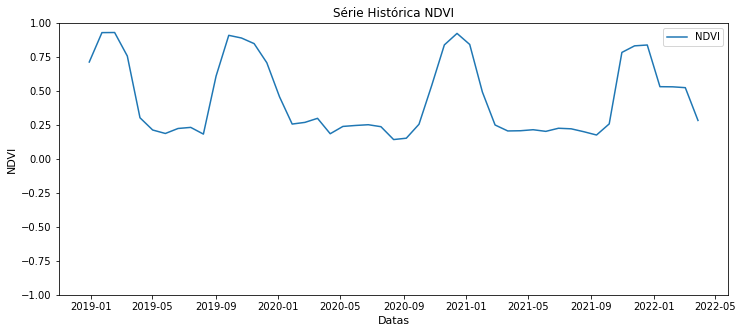

In [69]:
##Defina o tamanho da Figura
plt.figure(figsize=(12,5))
#Defina os parâmetros do gráfico
ax = sns.lineplot(data= df, x= 'data', y=49,label='NDVI') ##Dataframe da série histórica
##Legendas e eixos
plt.legend()
plt.title('Série Histórica NDVI')
plt.ylim((-1,1))
plt.ylabel('NDVI', fontsize=11)
plt.xlabel('Datas', fontsize=11)

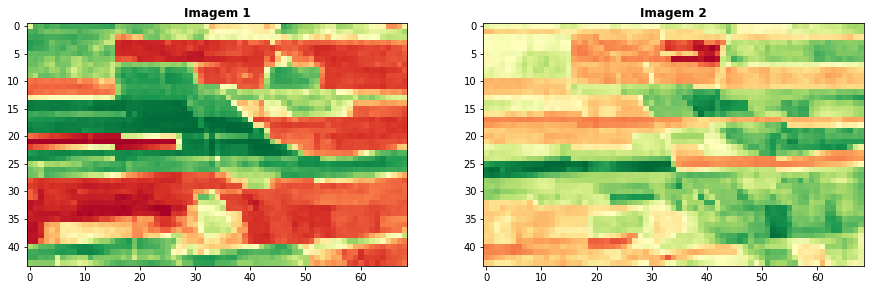

In [67]:
##Visualizando o comparativo entre as imagens 
fig, (axr, axg) = pyplot.subplots(1,2, figsize=(15,15))
show(img[:,:,0], ax=axr, cmap='RdYlGn', title='Imagem 1')
show(img[:,:,48], ax=axg, cmap='RdYlGn', title='Imagem 2')
plt.show()